# Analysis of compartment transitions
1. [ChIP-seq at transitions](#chip)
2. [Insulation and TAD boundaries at transitions](#TADs)

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import make_axes_locatable
import numpy as np

import bioframe

savedir = '../Fig3/'
if os.path.exists(savedir) is False:
    os.mkdir(savedir)
bigwig_dir = '../data/bigwigs/'
assembly = 'GRCh38'


/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  after removing the cwd from sys.path.


In [2]:
def state_to_state(state_from, state_to, states, hmm_track_key):
    return states.iloc[np.where( (np.diff(states[hmm_track_key].values)== (state_to-state_from)) &
                                 (states[hmm_track_key].values[:-1] == state_from) ) [0] ]

import astropy.convolution as astroconv
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = astroconv.convolve(y, box, boundary='extend') # also: None, fill, wrap, extend
    return y_smooth

import bbi
def symmetric_stackup(feature, flank, nbins, hmm_track, 
                      start_state, end_state, hmm_track_key):
    hmm_transitions = state_to_state(start_state, end_state, hmm_track, hmm_track_key)
    stackup = bbi.stackup(feature, 
                              hmm_transitions.chrom, 
                              hmm_transitions.end-flank, 
                              hmm_transitions.end+flank, 
                              bins=nbins)
    hmm_transitions_opposite = state_to_state(end_state, start_state, hmm_track, hmm_track_key)
    stackup_opposite = bbi.stackup(feature, 
                              hmm_transitions_opposite.chrom, 
                              hmm_transitions_opposite.end-flank, 
                              hmm_transitions_opposite.end+flank, 
                              bins=nbins)
    stackup_opposite = stackup_opposite[:,::-1]
    return np.vstack((stackup, stackup_opposite))


In [3]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_50kb.tsv', sep='\t')
bigwig_acc = pd.read_csv('../data/GM12878_bigwig_accesions.tsv',sep='\t')
for i in bigwig_acc['file_accession'].values:
    if os.path.exists(bigwig_dir+'/'+assembly+'/'+i+'.bigWig') is False:
        ec = bioframe.EncodeClient(bigwig_dir, assembly)
        try:
            print('trying to download '+i+' from Encode to bigwig_dir')
            ec.fetch(i)
        except: 
            print('could not download bigwig '+i)
    print('done')
bigwig_names =  ((bigwig_acc['biosample_term_name']+'_'+
                 (bigwig_acc['experiment_target'])).str.replace('-human','')+
                 bigwig_acc['suffixes']).values
bigwig_locs = (bigwig_dir+'/'+assembly+'/'+bigwig_acc['file_accession']+'.bigWig').values
            
bigwig_dict= dict(zip(bigwig_names, bigwig_locs))


trying to download ENCFF180LKW from Encode to bigwig_dir
could not download bigwig ENCFF180LKW
done
trying to download ENCFF167NBF from Encode to bigwig_dir
could not download bigwig ENCFF167NBF
done
trying to download ENCFF662QFK from Encode to bigwig_dir
could not download bigwig ENCFF662QFK
done
trying to download ENCFF682WPF from Encode to bigwig_dir
could not download bigwig ENCFF682WPF
done
trying to download ENCFF364OXN from Encode to bigwig_dir
could not download bigwig ENCFF364OXN
done
trying to download ENCFF368HBX from Encode to bigwig_dir
could not download bigwig ENCFF368HBX
done
done
done
done
done
done
done


In [4]:
state_name_dict = {
    4:'A',
    0:'B',
    3:'M_{aa}',
    1:'M_{bb}',
    2:'M' }
state_pairs_sym = [(4,3),(1,0),(4,2),(2,0) ] # observed transitions after postprocessing.

In [5]:
flank = 200000 # Length of flank to one side from the boundary, in basepairs
nbins = 200   # Number of bins to split the region
hmm_track_key = 'HMM3P'

## ChIP-seq at transitions <a name="chip"></a>

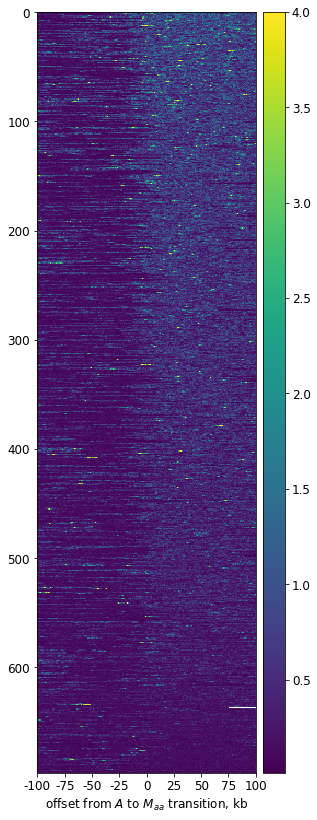

In [6]:

plt.rcParams['font.size'] = 12

start_state = 4
end_state = 3
for track in ['GM12878_H3K27me3_Broad']:
    
    f, ax = plt.subplots(figsize=(12, 14))
    
    stackup = symmetric_stackup(bigwig_dict[track],
                                flank, nbins, hmm_track, 
                                start_state, end_state, hmm_track_key)
    if 'H3K27me3' in track:
        norm =np.nanmean(stackup[:,100:],axis=1)
    else:
        norm =np.nanmean(stackup[:,:100],axis=1)
    
    sortind = np.argsort(norm)[::-1]
    im = ax.matshow(stackup[sortind,:],vmax=4); 
    plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
    plt.xlabel('offset from $'+state_name_dict[start_state]+
                       '$ to $'+state_name_dict[end_state]+'$ transition, kb')
    plt.gca().xaxis.set_ticks_position('bottom')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.1)#, aspect=6)
    plt.colorbar(im, cax=cax)

    plt.savefig(savedir+'heatmap_'+track+'_transition_'
                +str(start_state)+'_to_'+str(end_state)+'.png')

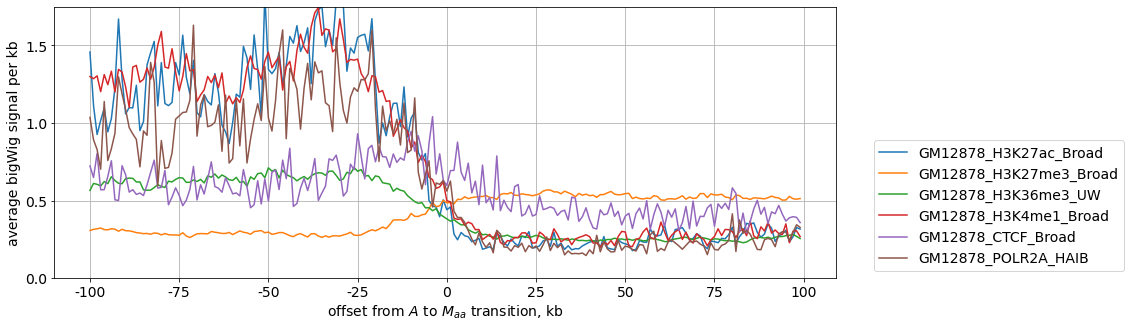

In [7]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(14,5))
start_state = 4
end_state = 3
for track in list(bigwig_dict.keys()):
    stackup = symmetric_stackup(bigwig_dict[track],
                                flank, nbins, hmm_track, 
                                start_state, end_state, hmm_track_key)
    plt.plot(smooth(np.nanmean(stackup,axis=0) ,1), label=track)#[::-1])    
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.ylim([0,1.75])
plt.yticks(np.arange(0,1.75,.5))
plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
plt.xlabel('offset from $'+state_name_dict[start_state]+
                       '$ to $'+state_name_dict[end_state]+'$ transition, kb')
    
plt.ylabel('average bigWig signal per kb')
plt.grid()
plt.savefig(savedir+'average_transition_'+str(start_state)+'_to_'+str(end_state)+'.png',
                bbox_inches ='tight')

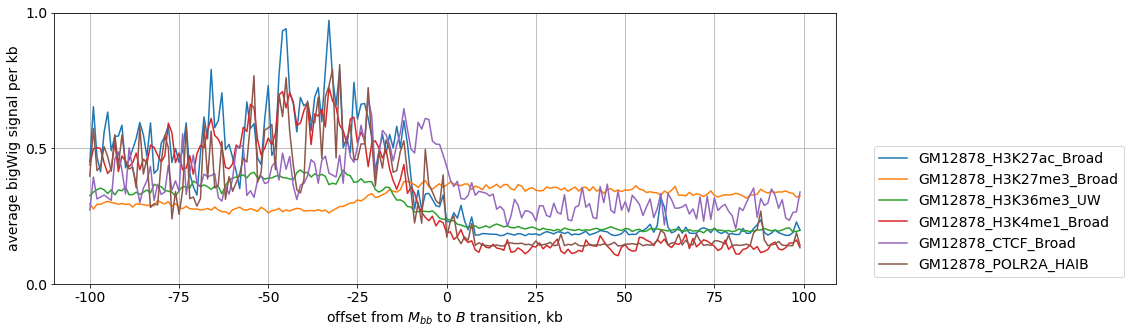

In [8]:
plt.rcParams['font.size'] = 14
plt.figure(figsize=(14,5))
start_state = 1
end_state = 0
for track in list(bigwig_dict.keys()):
    stackup = symmetric_stackup(bigwig_dict[track],
                                flank, nbins, hmm_track, 
                                start_state, end_state, hmm_track_key)
    plt.plot(smooth(np.nanmean(stackup,axis=0) ,1), label=track)#[::-1])    
    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
plt.ylim([0,1.0])
plt.yticks(np.arange(plt.ylim()[0],plt.ylim()[1]+.5,.5))
plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
plt.xlabel('offset from $'+state_name_dict[start_state]+
                       '$ to $'+state_name_dict[end_state]+'$ transition, kb')    
plt.ylabel('average bigWig signal per kb')
plt.grid()
plt.savefig(savedir+'average_transition_'+str(start_state)+'_to_'+str(end_state)+'.png',
                bbox_inches ='tight')

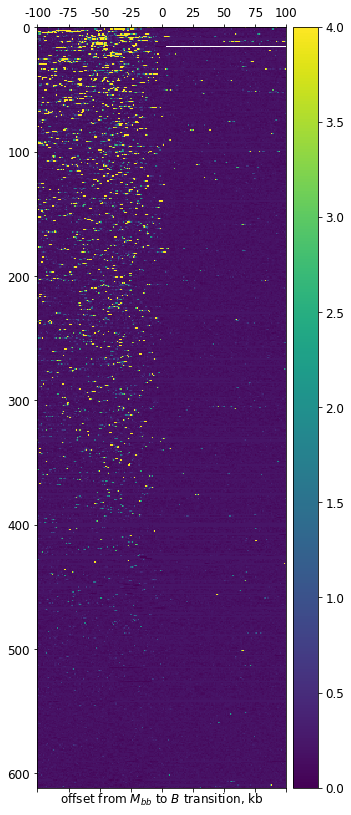

In [9]:
plt.rcParams['font.size'] = 12
start_state = 1
end_state = 0
for track in ['GM12878_H3K27ac_Broad']:
    
    f, ax = plt.subplots(figsize=(12, 14))
    
    stackup = symmetric_stackup(bigwig_dict[track],
                                flank, nbins, hmm_track, 
                      start_state, end_state, hmm_track_key)
    if 'H3K27me3' in track:
        norm =np.nanmean(stackup[:,100:],axis=1)
    else:
        norm =np.nanmean(stackup[:,:100],axis=1)
    
    sortind = np.argsort(norm)[::-1]
    im = ax.matshow(stackup[sortind,:],vmax=4); 
    plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
    plt.xlabel('offset from $'+state_name_dict[start_state]+
                       '$ to $'+state_name_dict[end_state]+'$ transition, kb')    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="10%", pad=0.1)#, aspect=6)
    plt.colorbar(im, cax=cax)

    plt.savefig(savedir+'heatmap_'+track+'_transition_'+str(start_state)+'_to_'+str(end_state)+'.png')

## Insulation and TAD boundaries at transitions <a name="TADs"></a>


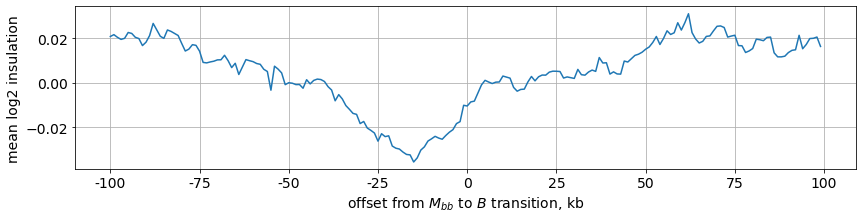

In [10]:
plt.rcParams['font.size'] = 14
plt.clf(); plt.close()
plt.figure(figsize=(14,3))
start_state = 1
end_state = 0
stackup = symmetric_stackup('../data/GM12878_inSitu_MboI.hg19.mapq_30.1000.insul.50000.bw',
                             flank, nbins, hmm_track, 
                             start_state, end_state, hmm_track_key)

plt.plot(smooth(np.nanmean(stackup,axis=0) ,1))#, label=track)#[::-1])

plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
plt.xlabel('offset from $'+state_name_dict[start_state]+
                       '$ to $'+state_name_dict[end_state]+'$ transition, kb')
plt.ylabel('mean log2 insulation')
plt.grid()
# #plt.savefig(savedir+'insulation_50k-window_vs_transition_'+str(start_state)+'_to_'+str(end_state)+'.png')

In [11]:


for smooth_window in [1,5,11]:
    plt.rcParams['font.size'] = 14
    plt.close(); plt.clf()
    plt.figure(figsize=(14,5))
    for state_pair in state_pairs_sym:
        start_state, end_state = state_pair
        stackup = symmetric_stackup('../data/GM12878_inSitu_MboI.hg19.mapq_30.1000.insul.50000.boundaries.bw',
                                     flank, nbins, hmm_track, 
                                     start_state, end_state, hmm_track_key)

        plt.plot(smooth(np.nanmean(stackup,axis=0) ,smooth_window), 
                 label = ('$'+state_name_dict[start_state]+'$ to $'+
                          state_name_dict[end_state]+'$'))

    lgd = plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")

    plt.ylim([0,0.02])
    plt.yticks(np.linspace(0,0.02,5))
    plt.ylabel('freq of boundary per kb')

    plt.xticks(np.arange(0,nbins+25,25),
              (np.arange(-nbins//2,nbins//2+25,25)*flank/nbins//1000).astype(int))
    plt.xlabel('offset from $'+state_name_dict[start_state]+
                           '$ to $'+state_name_dict[end_state]+'$ transition, kb')

    plt.savefig(savedir+'GM12878-boundaries_all-transitions_smooth-bins'+str(smooth_window)+'.png', 
     bbox_inches ='tight')

ValueError: Start exceeds the chromosome length, 81195210.

<Figure size 432x288 with 0 Axes>

<Figure size 1008x360 with 0 Axes>